<a href="https://colab.research.google.com/github/Ziqi-Li/GIS5122/blob/main/assignments/GIS5122_A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 4
**Due date/time:** Mar 29th Fri 23:59pm

**Instruction**: Make a copy of this notebook and read through the questions and instructions. Write down code/text to perform the analysis.

**Submission**: After you finish working on this notebook, click File->Download->Download .ipynb

Please submit a notebook named A4_your_name.ipynb on Canvas.

## Detailed instructions:

In this assignment, we will practice modeling spatial heterogeneity using geographically weighted regression models

**Note**: From this assignment and onward, if you are interested in performing your analysis using your own data (e.g., you may have a dataset from a research project), you are very encouraged to do so.

We will be re-using our data and model specifications from Assignment 3. For the same set of dependent variable (y) and independent variables (X):

1. Fit a GWR model and an MGWR model. Note, MGWR may take a while to finish. Also make sure you standardize your variables before model fitting. (2%)
2. Compare the models in terms of a) R², b) AICc, and c) spatial autocorrelation in the model residuals. Indicate which model performs better for your data. (2%)
3. Make maps of your spatially varying coefficients with adjustments for multiple testing (make insignificant coefficients grey). (3%)
4. Describe the spatial pattern you observe in your maps of spatially varying coefficients. Hints: Comment on the general pattern, magnitude, sign of the coefficients, and spatial scale of the relationship, etc. (3%)



You may need to install these three packages if working on colab:

In [1]:
pip install -q libpysal

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install -q splot

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install -q mgwr

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install -q esda


Note: you may need to restart the kernel to use updated packages.


Import all the packages needed to run the analysis

In [35]:
import geopandas as gpd
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

from libpysal.weights import Queen
from esda.moran import Moran
#MGWR functions
from mgwr.gwr import GWR,MGWR
from mgwr.sel_bw import Sel_BW

Code to read in data and merge them into one final `GeoDataFrame`.

In [8]:
health_url = "https://raw.github.com/Ziqi-Li/GIS5122/main/data/cdc_health_county.csv"
health = pd.read_csv(health_url)

In [9]:
socio_demo_url = "https://raw.github.com/Ziqi-Li/GIS5122/main/data/acs_2019.csv"
socio_demo = pd.read_csv(socio_demo_url)

In [10]:
counties_url = "https://raw.github.com/Ziqi-Li/gis5122/master/data/us_counties.geojson"
counties = gpd.read_file(counties_url)

In [11]:
income_health = pd.merge(socio_demo, health, left_on = "county_id", right_on = "LocationID")

In [12]:
gdf_income_health = pd.merge(counties, income_health, on = "county_id")

Your code will start here, and your analysis will be based on this GeoDataFrame `gdf_income_health`.

## Fit a GWR model and an MGWR model. Note, MGWR may take a while to finish. Also make sure you standardize your variables before model fitting. (2%)

In [18]:
gdf_income_health[['median_income']] = gdf_income_health[['median_income']]/10000

In [21]:
variable_names = ['sex_ratio', 'median_income', 'gini',
                  'pct_age_18_29', 'pct_65_over', 'pct_bach']


y = gdf_income_health[['OBESITY']].values

X = gdf_income_health[variable_names].values

In [24]:
X = (X - X.mean(axis=0))/X.std(axis=0)
y = (y - y.mean(axis=0))/y.std(axis=0)

In [27]:
coords = gdf_income_health[['proj_X', 'proj_Y']].values

### GWR model

In [28]:
gwr_selector = Sel_BW(coords, y, X)

gwr_bw = gwr_selector.search(verbose=True)

print("Selected optimal bandwidth is:", gwr_bw)

Bandwidth:  1219.0 , score:  5564.63
Bandwidth:  1938.0 , score:  5877.83
Bandwidth:  774.0 , score:  5305.76
Bandwidth:  499.0 , score:  5097.98
Bandwidth:  329.0 , score:  4933.38
Bandwidth:  224.0 , score:  4835.12
Bandwidth:  159.0 , score:  4781.56
Bandwidth:  119.0 , score:  4789.04
Bandwidth:  184.0 , score:  4798.59
Bandwidth:  144.0 , score:  4780.27
Bandwidth:  134.0 , score:  4779.93
Bandwidth:  129.0 , score:  4781.11
Bandwidth:  138.0 , score:  4779.13
Bandwidth:  140.0 , score:  4779.52
Bandwidth:  136.0 , score:  4779.58
Selected optimal bandwidth is: 138.0


In [29]:
gwr_results = GWR(coords, y, X, bw=gwr_bw,name_x=variable_names).fit()

In [30]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                3103
Number of covariates:                                                     7

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           1429.710
Log-likelihood:                                                   -3200.713
AIC:                                                               6415.425
AICc:                                                              6417.472
BIC:                                                             -23462.516
R2:                                                                   0.539
Adj. R2:                                                              0.538

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

Checkout the residuals of from the GWR model.

In [45]:
#Here we use the Queen contiguity
w = Queen.from_dataframe(gdf_income_health)

#row standardization
w.transform = 'R'

residual_moran = Moran(gwr_results.resid_response.reshape(-1), w)
residual_moran.I

C:\Users\weini\AppData\Local\Temp\ipykernel_2912\2531743358.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gdf_income_health)


('WARNING: ', 2441, ' is an island (no neighbors)')
('WARNING: ', 2701, ' is an island (no neighbors)')


C:\Users\weini\anaconda3\Lib\site-packages\libpysal\weights\weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 2441, 2701.
  warnings.warn(message)


0.06766134015918826

### MGWR model

In [40]:
%%time

mgwr_selector = Sel_BW(coords, y, X,multi=True)
mgwr_bw = mgwr_selector.search(verbose=True)

print("Selected optimal bandwidth is:", mgwr_bw)

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Current iteration: 1 ,SOC: 0.0036863
Bandwidths: 44.0, 316.0, 92.0, 238.0, 165.0, 175.0, 147.0
Current iteration: 2 ,SOC: 0.0019701
Bandwidths: 44.0, 467.0, 120.0, 354.0, 291.0, 251.0, 207.0
Current iteration: 3 ,SOC: 0.001419
Bandwidths: 44.0, 621.0, 151.0, 412.0, 411.0, 311.0, 342.0
Current iteration: 4 ,SOC: 0.0010909
Bandwidths: 44.0, 853.0, 161.0, 448.0, 746.0, 368.0, 449.0
Current iteration: 5 ,SOC: 0.0008881
Bandwidths: 44.0, 936.0, 183.0, 489.0, 1924.0, 380.0, 519.0
Current iteration: 6 ,SOC: 0.0006489
Bandwidths: 44.0, 1131.0, 183.0, 490.0, 2484.0, 393.0, 600.0
Current iteration: 7 ,SOC: 0.000501
Bandwidths: 44.0, 1229.0, 183.0, 490.0, 3101.0, 397.0, 619.0
Current iteration: 8 ,SOC: 0.0003911
Bandwidths: 44.0, 1456.0, 183.0, 490.0, 3101.0, 423.0, 659.0
Current iteration: 9 ,SOC: 0.0003336
Bandwidths: 44.0, 1567.0, 183.0, 490.0, 3101.0, 443.0, 730.0
Current iteration: 10 ,SOC: 0.0002666
Bandwidths: 44.0, 1590.0, 183.0, 490.0, 3101.0, 447.0, 730.0
Current iteration: 11 ,SOC: 0.0

In [41]:
mgwr_results = MGWR(coords, y, X, selector=mgwr_selector,name_x=variable_names).fit()

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

In [42]:
mgwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                3103
Number of covariates:                                                     7

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           1429.710
Log-likelihood:                                                   -3200.713
AIC:                                                               6415.425
AICc:                                                              6417.472
BIC:                                                             -23462.516
R2:                                                                   0.539
Adj. R2:                                                              0.538

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [49]:
#Here we use the Queen contiguity
w = Queen.from_dataframe(gdf_income_health)

#row standardization
w.transform = 'R'

residual_moran = Moran(mgwr_results.resid_response.reshape(-1), w)
residual_moran.I

C:\Users\weini\AppData\Local\Temp\ipykernel_2912\4245755842.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gdf_income_health)


('WARNING: ', 2441, ' is an island (no neighbors)')
('WARNING: ', 2701, ' is an island (no neighbors)')


C:\Users\weini\anaconda3\Lib\site-packages\libpysal\weights\weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 2441, 2701.
  warnings.warn(message)


-0.0042248268180293804

## Compare the models in terms of a) R², b) AICc, and c) spatial autocorrelation in the model residuals. Indicate which model performs better for your data. (2%)

The **MGWR model** outperforms both OLS and GWR across R², AICc, and Moran's I, suggesting it not only fits the data better but also effectively reduces spatial autocorrelation in the residuals.

**R²:** The **MGWR model** has the highest R², indicating it explains the most variability in the data. The GWR model is next, and the OLS model has the lowest R² value.  
**AICc:** Among the three models, the **MGWR model** has the lowest AICc, suggesting the best fit when accounting for model complexity. The GWR model is next, with OLS having the highest AICc.  
**Moran's I:** The GWR also improves upon spatial autocorrelation but not as significantly as **MGWR**. OLS, on the other hand, has the highest Moran's I, indicating substantial spatial autocorrelation, which is undesirable.

In [52]:
data = {
    ' ': ['R²', 'AICc', "Moran's I of residuals"],
    'OLS': [0.539, 6417.472, 0.48],
    'GWR': [0.765, 4779.128, 0.0676],
    'MGWR': [0.801, 4398.984, -0.0042]
}

df = pd.DataFrame(data)

df

,,OLS,GWR,MGWR
0,R²,0.539,0.7650,0.8010
1,AICc,6417.472,4779.1280,4398.9840
2,Moran's I of residuals,0.480,0.0676,-0.0042


## Make maps of your spatially varying coefficients with adjustments for multiple testing (make insignificant coefficients grey). (3%)

In [54]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mgwr.utils import shift_colormap,truncate_colormap
from matplotlib import cm,colors

def param_plots(result, gdf, names=[], filter_t=False,figsize=(10, 10)):
    
    #Size of the plot. Here we have a 2 by 2 layout.
    k = gwr_results.k
    
    fig, axs = plt.subplots(int(k/2)+1, 2, figsize=figsize)
    axs = axs.ravel()
    
    #The max and min values of the color bar.
    vmin = -0.8
    vmax = 0.8
    
    cmap = cm.get_cmap("bwr_r")
    norm = colors.BoundaryNorm(np.arange(-0.8,0.9,0.1),ncolors=256)
    
    for j in range(k):
        
        pd.concat([gdf,pd.DataFrame(np.hstack([result.params,result.bse]))],axis=1).plot(ax=axs[j],column=j,vmin=vmin,vmax=vmax,
                                                                                         cmap=cmap,norm=norm,linewidth=0.1,edgecolor='white',aspect=1)
        axs[j].set_title("Parameter estimates of \n" + names[j],fontsize=10)
        
        if filter_t:
            rslt_filtered_t = result.filter_tvals()
            if (rslt_filtered_t[:,j] == 0).any():
                gdf[rslt_filtered_t[:,j] == 0].plot(color='lightgrey', ax=axs[j],linewidth=0.1,edgecolor='white',aspect=1)
        
        plt.axis('off')
    
    fig = axs[j].get_figure()
    cax = fig.add_axes([0.99, 0.2, 0.025, 0.6])
    sm = plt.cm.ScalarMappable(cmap=cmap,norm=norm)
    # fake up the array of the scalar mappable. Urgh...
    sm._A = []
    fig.colorbar(sm, cax=cax)

### GWR

C:\Users\weini\AppData\Local\Temp\ipykernel_2912\1374554983.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("bwr_r")


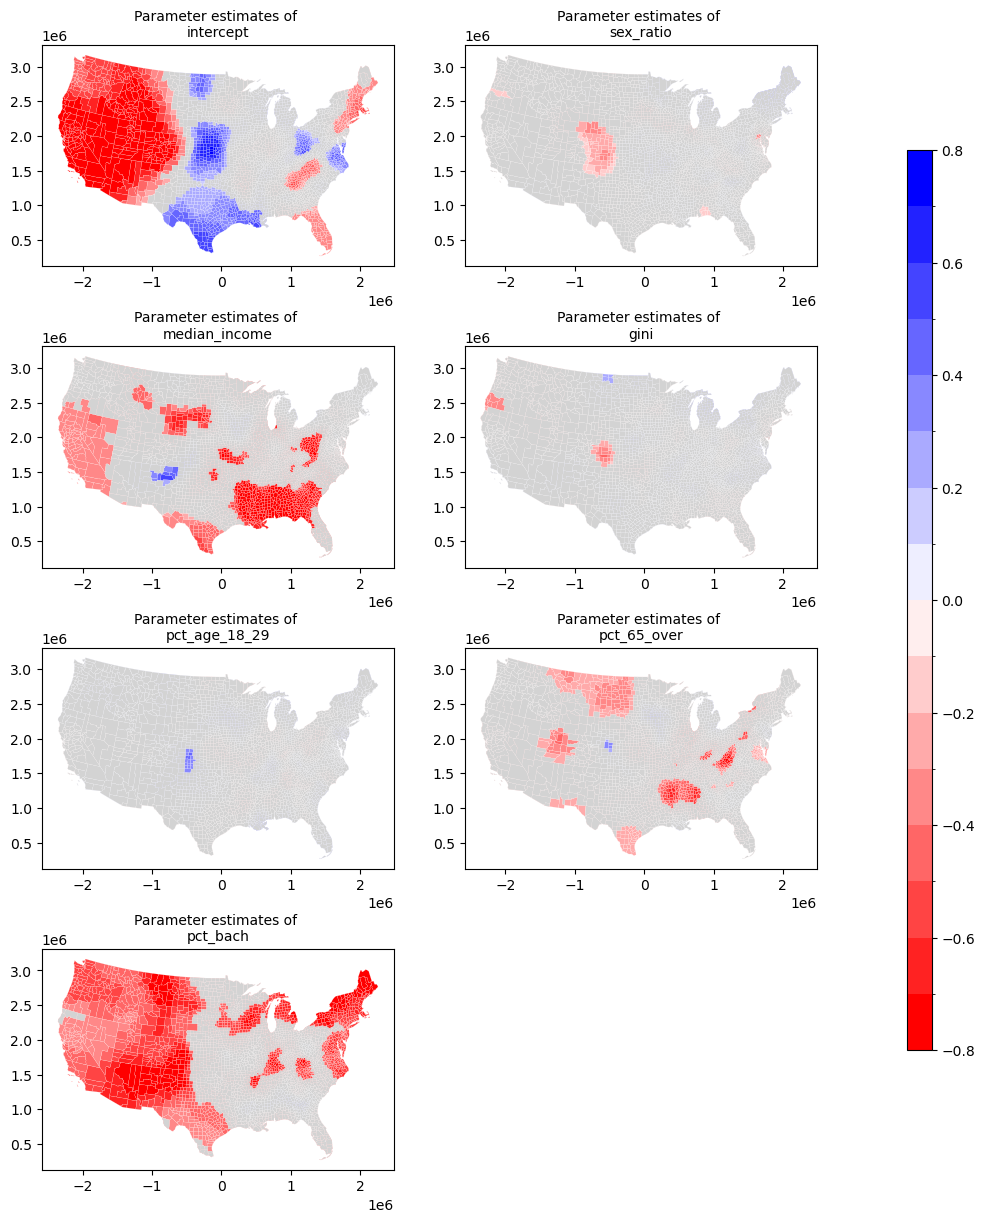

In [55]:
param_plots(gwr_results, gdf_income_health, names=['intercept'] + variable_names,figsize = (10,15), filter_t=True)

### MGWR

C:\Users\weini\AppData\Local\Temp\ipykernel_2912\1374554983.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("bwr_r")


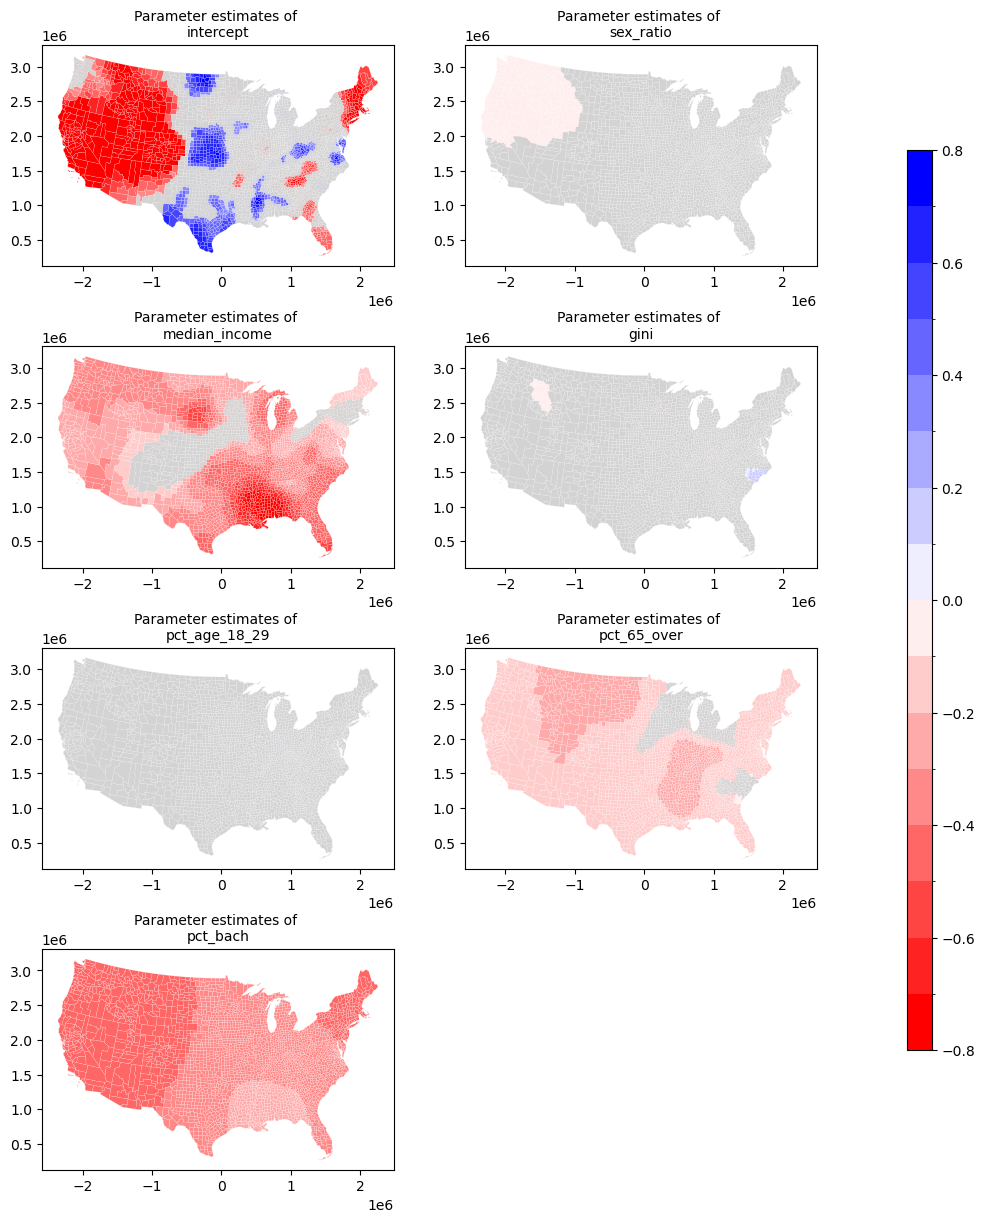

In [57]:
param_plots(mgwr_results, gdf_income_health, names=['intercept'] + variable_names,figsize = (10,15), filter_t=True)

## Describe the spatial pattern you observe in your maps of spatially varying coefficients. Hints: Comment on the general pattern, magnitude, sign of the coefficients, and spatial scale of the relationship, etc. (3%)

**GWR**:  
Most areas exhibit a deep red, suggesting a strong negative (red) association between the intercept and obesity rates across much of the western United States. This implies that there are other factors contributing to lower obesity rates in these regions. The Southern and middle parts show a few blue spots indicating a positive association.

**Sex Ratio:** Most of the counties does not show a significant relationship with obesity, indicated by the gray color. However, there are a few counties of slight negative relationships (light red) scattered in the central United States, suggesting that in these particular areas, a lower sex ratio is associated with higher obesity rates.
**Median Income:** The map is predominantly deep red in the southeast United States, suggesting a strong negative relationship, and there are a few counties of slight negative relationships scatterd in the west United States. Higher median incomes tend to be associated with lower obesity rates. However, there are a few blue spots, which suggest that in these particular areas, there might be a positive relationship.
**Gini Coefficient:** The map does not show a strong spatial pattern. There are a few light blue areas, suggesting a slight positive association in those regions.
**Percentage of Age 18-29**: The map shows almost no color, indicating that this age group's percentage of the population generally does not have a significant spatial relationship with obesity. 
**Percentage of Age 65 and Over**: The red areas on the map indicate a negative relationship between the percentage of older adults and obesity rates, while the few blue areas show a slight positive relationship.
**Percentage with a Bachelor's Degree**: There is a broad area of deep red, particularly in the western region and central-western region, indicating a strong positive relationship between higher education levels and obesity rates. Some deep red areas in the northeast region suggest a strong negative relationship in those places.

**MGWR:**  
Most areas exhibit a deep red, suggesting a strong negative (red) association between the intercept and obesity rates across much of the western and northeastern United States. This implies that there are other factors contributing to lower obesity rates in these regions. The Southern and middle parts show a few blue spots indicating a positive association.  

**Sex Ratio:** Most of the counties does not show a significant relationship with obesity, indicated by the gray color. However, there are a few counties of slight negative relationships (light red) scattered in the northwestern area, suggesting that in these particular areas, a lower sex ratio is associated with higher obesity rates.
**Median Income, Percentage of Age 65 and Over:** The map is predominantly red in the United States but the central area, suggesting a strong negative relationship.
**Gini Coefficient, Percentage of Age 18-29:** The map does not show a strong spatial pattern. 
**Percentage with a Bachelor's Degree**: All the area in red, particularly in the western region and northeast region, indicating a strong positive relationship between higher education levels and obesity rates. Some deep red areas in the northeast region suggest a strong negative relationship in those places.